<a href="https://colab.research.google.com/github/mountainway184/Deraining/blob/master/%5BRain100L%5DBMVC(Default).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Apr  6 04:42:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.1.0
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,MaxPooling2D,concatenate,Add
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.optimizers import Adam

import os,re,random,time
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio #PSNR
from skimage.metrics import structural_similarity #SSIM

from google.colab import drive
drive.mount('/content/drive')
tf.test.gpu_device_name()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Mounted at /content/drive


'/device:GPU:0'

In [3]:
#training dataとLabel dataをセットで読み込んでcrop(パッチサイズで切り抜くこと)をし出力
def read_data(input_path, gt_path,input_files, gt_files, size_input, num_channel, batch_size):
    Data  = np.zeros((batch_size, size_input, size_input, num_channel),dtype=np.float32) 
    Label = np.zeros((batch_size, size_input, size_input, num_channel),dtype=np.float32) 
  
    for i in range(batch_size): 
        #画像をランダムに選択
        r_idx = random.randint(0,len(input_files)-1)
        input_file=gt_files[r_idx][:-4]+"x2.png" 
        rainy = img.imread(input_path + input_file)           
        label = img.imread(gt_path + gt_files[r_idx])
        #random crop
        x = random.randint(0,rainy.shape[0] - size_input)
        y = random.randint(0,rainy.shape[1] - size_input)
        subim_input = rainy[x : x+size_input, y : y+size_input, :]
        subim_label = label[x : x+size_input, y : y+size_input, :]
        subim_input = subim_input*2.0-1.0#normalize(1~-1の範囲に変換)
        subim_label = subim_label*2.0-1.0
        #"Data,Label"に切り抜いた画像を格納
        Data[i,:,:,:] = subim_input
        Label[i,:,:,:] = subim_label
    return Data, Label

Shape: (2, 256, 256, 3)
Maximum value of a pixel: 1.0
Minimum value of a pixel: 0.07058823


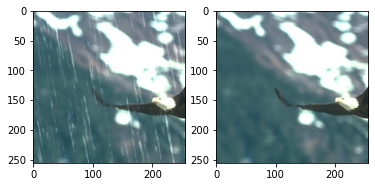

In [4]:
BUFFER_SIZE = 1800
BATCH_SIZE = 2
PATCH_SIZE = 256
NUM_CHANNEL = 3

INPUT_PATH = '/content/drive/My Drive/Database/Deraining/Training_data/Rain100L/Input/'#training data(input)
GT_PATH ='/content/drive/My Drive/Database/Deraining/Training_data/Rain100L/Label/'#training data(Ground Truth)
TEST_INP_PATH = '/content/drive/My Drive/Database/Deraining/Test_data/Rain100L/Input/'#test data(input)
TEST_GT_PATH = '/content/drive/My Drive/Database/Deraining/Test_data/Rain100L/Label/'#test data(Ground Truth)

input_files = os.listdir(INPUT_PATH) 
gt_files = os.listdir(GT_PATH) 
data,label  = read_data(INPUT_PATH, GT_PATH,input_files, gt_files, PATCH_SIZE, NUM_CHANNEL, BATCH_SIZE)
data[0,:,:,:] = data[0,:,:,:]/2  +0.5 #表示するために数値をずらす(1~0)
label[0,:,:,:] = label[0,:,:,:]/2 +0.5 

plt.subplot(1,2,1)
plt.imshow(data[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(label[0,:,:,:])
print("Shape:" ,label.shape)
print("Maximum value of a pixel:",np.max(data[0,:,:,:]))#画素の最大値
print("Minimum value of a pixel:",np.min(data[0,:,:,:]))#画素の最小値

In [5]:
f = [64,128,256,512]#フィルター数

#U-Netのネットワークを構築
def Generator(input_size = (None,None,None,NUM_CHANNEL)):
    inputs = Input(batch_shape = (None,None,None,NUM_CHANNEL))

    conv1 = Conv2D(f[0], (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(f[0], (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(f[1], (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(f[1], (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(f[2], (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(f[2], (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(f[3], (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(f[3], (3, 3), activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(f[2], (2, 2), strides=(2, 2), activation='relu', padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv6 = Conv2D(f[2], (3, 3), activation='relu', padding='same')(up5)
    conv6 = Conv2D(f[2], (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(f[1], (2, 2), strides=(2, 2), activation='relu', padding='same')(conv6)   
    up7 = concatenate([up7, conv2], axis=3) 
    conv8 = Conv2D(f[1], (3, 3), activation='relu', padding='same')(up7)
    conv8 = Conv2D(f[1], (3, 3), activation='relu', padding='same')(conv8)  

    up9 = Conv2DTranspose(f[0], (2, 2), strides=(2, 2), activation='relu', padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)     
    conv10 = Conv2D(f[0], (3, 3), activation='relu', padding='same')(up9)
    conv10 = Conv2D(f[0], (3, 3), activation='relu', padding='same')(conv10)

    conv11 = Conv2D(3,(3, 3),padding='same')(conv10)

    model = Model(inputs=[inputs], outputs=[conv11])
    return model

In [6]:
gen_model = Generator(data)
gen_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.9)#Optimizer(Adam)
gen_checkpoint_dir = '/content/drive/My Drive/Database/Deraining/Yamamichi/BMCV2021/Rain100L/Default/'
gen_checkpoint_prefix = os.path.join(gen_checkpoint_dir, "ckpt")
gen_checkpoint = tf.train.Checkpoint(generator_optimizer=gen_generator_optimizer, generator=gen_model)

In [ ]:
gen_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 36928       conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 6 0           conv2d_16[0][0]                  
____________________________________________________________________________________________

In [7]:
def generator_loss(gen_output, target):#MAE_Loss
  return tf.reduce_mean(tf.abs(target - gen_output))
  
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape:
    gen_output = gen_model(input_image)
    gen_loss = generator_loss(gen_output, target)
  generator_gradients = gen_tape.gradient(gen_loss,gen_model.trainable_variables)
  gen_generator_optimizer.apply_gradients(zip(generator_gradients, gen_model.trainable_variables))
  return gen_loss

In [8]:
def train(epochs):
  if tf.train.get_checkpoint_state(gen_checkpoint_dir):#フォルダにモデルがある場合
    print('Loading model...')
    ckpt = tf.train.latest_checkpoint(gen_checkpoint_dir)#一番新しいモデルのパスを読み込み
    #ckpt = gen_checkpoint_dir+'ckpt-43'#指定したモデルを復元したい場合はこっち
    gen_checkpoint.restore(ckpt)#指定したモデルを復元
    print("Restored the model.")
    print(ckpt)
    #ckpt_num = re.findall(r'(\w*[0-9]+)\w*',ckpt)
    #start_point = int(ckpt_num[0])
    start_point = int(288)
    print('Start learning from :',start_point, 'epoch.')
  else:
    start_point = 0
    print('Start learning.')

  gen_loss_list = []
  val_psnr_list = []
  val_ssim_list = []
  iteration = int(BUFFER_SIZE/BATCH_SIZE)

  for epoch in range(start_point,epochs):
    start = time.time()
    total_gen_loss = 0.0
    for i in range(iteration):
      input_image,target  = read_data(INPUT_PATH, GT_PATH,input_files,
                                      gt_files, PATCH_SIZE, NUM_CHANNEL,
                                      BATCH_SIZE)
      gen_loss = train_step(input_image, target)
      total_gen_loss += gen_loss.numpy()
      print("\r%d / %d"%(i,iteration), end='')
    total_gen_loss /= i
    gen_loss_list.append(total_gen_loss)
    print()
    print('=======================================================================')
    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
    print("gen_loss:",gen_loss_list)

    val_psnr = 0
    val_ssim = 0
    for i in range(200):
      print("\r%d / %d"%(i,200), end='')
      test_inp = np.array(img.imread(TEST_INP_PATH+'norain-%dx2.png'%(i+1)))
      test_label = np.array(img.imread(TEST_GT_PATH+'norain-%d.png'%(i+1)))
      test_inp = test_inp[np.newaxis,:,:,:]
      test_inp = test_inp*2.0-1  
      if test_inp.shape[1]%2 == 1:
        test_inp = test_inp[:,:-1,:,:]
        test_label = test_label[:-1,:,:]
      if test_inp.shape[2]%2 == 1:
        test_inp = test_inp[:,:,:-1,:]
        test_label = test_label[:,:-1,:]
      test_inp = gen_model(test_inp)
      test_inp = np.squeeze(test_inp,0)
      test_inp = (test_inp+1.0)/2
      val_psnr += peak_signal_noise_ratio(test_inp,test_label,data_range=1)#PSNR
      val_ssim += structural_similarity(test_inp,test_label,data_range=1,multichannel=True)#SSIM
    psnr = val_psnr/200
    ssim = val_ssim/200
    val_psnr_list.append(psnr)#リストに格納
    val_ssim_list.append(ssim)
    print()
    print('val_psnr',val_psnr_list)
    print('val_ssim',val_ssim_list)
    print('=======================================================================')
    if psnr==max(val_psnr_list):
      print('model saved.')
      gen_checkpoint.save(file_prefix = gen_checkpoint_prefix)#モデルを保存

Rain100L

In [ ]:
EPOCH = 300#1回目
train(EPOCH)

Start learning.
899 / 900
Time taken for epoch 1 is 318.9982829093933 sec

gen_loss: [0.07258599714580115]
199 / 200
val_psnr [28.58900381472129]
val_ssim [0.8989025226240127]
model saved.
899 / 900
Time taken for epoch 2 is 195.03060579299927 sec

gen_loss: [0.07258599714580115, 0.04380557382141589]
199 / 200
val_psnr [28.58900381472129, 30.326318223376965]
val_ssim [0.8989025226240127, 0.922859556231804]
model saved.
899 / 900
Time taken for epoch 3 is 158.24801325798035 sec

gen_loss: [0.07258599714580115, 0.04380557382141589, 0.03834311535231794]
199 / 200
val_psnr [28.58900381472129, 30.326318223376965, 30.484450721384405]
val_ssim [0.8989025226240127, 0.922859556231804, 0.9281531082614102]
model saved.
899 / 900
Time taken for epoch 4 is 140.4169418811798 sec

gen_loss: [0.07258599714580115, 0.04380557382141589, 0.03834311535231794, 0.03445757723395797]
199 / 200
val_psnr [28.58900381472129, 30.326318223376965, 30.484450721384405, 31.264097079302765]
val_ssim [0.8989025226240127,

In [ ]:
EPOCH = 300#2回目
train(EPOCH)

Loading model...
Restored the model.
/content/drive/My Drive/Database/Deraining/Yamamichi/BMCV2021/Rain100L/Default/ckpt-23
Start learning from : 84 epoch.
899 / 900
Time taken for epoch 85 is 883.0863404273987 sec

gen_loss: [0.01632103108458047]
199 / 200
val_psnr [35.507859679044266]
val_ssim [0.9739185211889955]
model saved.
899 / 900
Time taken for epoch 86 is 383.7212975025177 sec

gen_loss: [0.01632103108458047, 0.016147870623772844]
199 / 200
val_psnr [35.507859679044266, 36.2106735243598]
val_ssim [0.9739185211889955, 0.9767739038633343]
model saved.
899 / 900
Time taken for epoch 87 is 193.83975219726562 sec

gen_loss: [0.01632103108458047, 0.016147870623772844, 0.01654471995700586]
199 / 200
val_psnr [35.507859679044266, 36.2106735243598, 35.985818044117465]
val_ssim [0.9739185211889955, 0.9767739038633343, 0.9755382131226473]
899 / 900
Time taken for epoch 88 is 122.62067866325378 sec

gen_loss: [0.01632103108458047, 0.016147870623772844, 0.01654471995700586, 0.015908819602

In [ ]:
EPOCH = 300#3回目
train(EPOCH)

Loading model...
Restored the model.
/content/drive/My Drive/Database/Deraining/Yamamichi/BMCV2021/Rain100L/Default/ckpt-35
Start learning from : 195 epoch.
899 / 900
Time taken for epoch 196 is 779.914214849472 sec

gen_loss: [0.013100030433668343]
199 / 200
val_psnr [36.44942044533948]
val_ssim [0.9779323342094053]
model saved.
899 / 900
Time taken for epoch 197 is 339.0519771575928 sec

gen_loss: [0.013100030433668343, 0.01340512368046949]
199 / 200
val_psnr [36.44942044533948, 36.41951746611291]
val_ssim [0.9779323342094053, 0.978250335625292]
899 / 900
Time taken for epoch 198 is 187.25051546096802 sec

gen_loss: [0.013100030433668343, 0.01340512368046949, 0.013110229006354118]
199 / 200
val_psnr [36.44942044533948, 36.41951746611291, 36.289736482233565]
val_ssim [0.9779323342094053, 0.978250335625292, 0.9778132167376061]
899 / 900
Time taken for epoch 199 is 145.40230417251587 sec

gen_loss: [0.013100030433668343, 0.01340512368046949, 0.013110229006354118, 0.013194511873488034]
1

In [9]:
EPOCH = 300#4回目
train(EPOCH)

Loading model...
Restored the model.
/content/drive/My Drive/Database/Deraining/Yamamichi/BMCV2021/Rain100L/Default/ckpt-47
Start learning from : 288 epoch.
899 / 900
Time taken for epoch 289 is 885.1174738407135 sec

gen_loss: [0.012097964888424078]
199 / 200
val_psnr [36.641267346324824]
val_ssim [0.9788676146354686]
model saved.
899 / 900
Time taken for epoch 290 is 356.05301451683044 sec

gen_loss: [0.012097964888424078, 0.012361304898714197]
199 / 200
val_psnr [36.641267346324824, 36.5068968106353]
val_ssim [0.9788676146354686, 0.9784952371666793]
899 / 900
Time taken for epoch 291 is 211.49119544029236 sec

gen_loss: [0.012097964888424078, 0.012361304898714197, 0.012452343876087195]
199 / 200
val_psnr [36.641267346324824, 36.5068968106353, 36.7220362488871]
val_ssim [0.9788676146354686, 0.9784952371666793, 0.9790468382672991]
model saved.
899 / 900
Time taken for epoch 292 is 151.11913633346558 sec

gen_loss: [0.012097964888424078, 0.012361304898714197, 0.012452343876087195, 0.01